## Part 2: Model exploration

## Now we will attempt to train some additional models:
### 1. Logistic Regression
### 2. Decision Tree
### 3. Random Forest
### 4. Gradient Boosting Machines (GBM)
### 5. Improve upon GBM via hyper-parameter tuning
### 6. Evaluation

see `4-pup-BERT.ipynb` for BERT implementation

In [77]:
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from urllib.parse import urlparse
import xgboost as xgb
from xgboost import plot_importance

### All of the code to process the dataset can be found in `1-pup.ipynb`:

Step 1: Lexical features extraction: split URLs into components, apply a sliding window to the domain, and use a bag-of-words model to describe each component.

In [78]:
def lexicalFE(url): #lexical feature extraction fn - takes in a URL
    if not urlparse(url).scheme:
        url = 'http://' + url  # prepend with default scheme
    
    try:
        parsedURL = urlparse(url)
        domain = parsedURL.netloc
        path = parsedURL.path
        query = parsedURL.query
        domainNoPrefix = domain.replace('www.', '')
        features = {
            'domain': domain,
            'domainNoPrefix': domainNoPrefix,
            'domainLength': len(domain),
            'pathLength': len(path),
            'queryLength': len(query),
            'numPathComponents': len(path.split('/')) - 1,  # Subtracting 1 because the leading '/' results in an empty string at the start
            'numQueryComponents': len(query.split('&')) if query else 0,  # Only count if there's a query
            'hasDigitsInDomain': any(char.isdigit() for char in domain),
            'hasDigitsInPath': any(char.isdigit() for char in path),
            'hasDigitsInQuery': any(char.isdigit() for char in query)
        }
        return features
    except ValueError as e: #handle errors TODO: more here
        print(f"Error processing URL {url}: {e}")
        return {}

Step 2: descriptive features extraction - this function will further split the path component, remove common prefixes and TLDs, and calc stats

In [79]:
def descriptiveFE(url): #descriptive feature extraction fn - takes in a URL
    parsedURL = urlparse(url)
    domain = parsedURL.netloc.replace('www.', '')  # Remove common prefix
    path = parsedURL.path
    query = parsedURL.query
    path_components = path.split('/') # further split the path
    filename = path_components[-1] if '.' in path_components[-1] else None
    fileBool = 1 if filename else 0
    file_extension = filename.split('.')[-1] if filename else None
    
    # Calculate statistics
    features = {
        'domainLength': len(domain),
        'pathLength': len(path),
        'queryLength': len(query),
        'numPathComponents': len(path_components),
        'filename': filename,
        'fileNamePresent': fileBool,
        'fileExtension': file_extension,
        'isIpAdress': bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain)),
        'fileExecutable': file_extension in ['exe', 'bin', 'bat']
    }
    return features

In [80]:
df = pd.read_csv('./datasets/conglom-labeled.csv', names=['URL', 'Classification'])

Apply lexical and descriptive feature extraction

In [81]:
df['Lexical_Features'] = df['URL'].apply(lambda x: lexicalFE(x))
df['Descriptive_Features'] = df['URL'].apply(lambda x: descriptiveFE(x))
testIndex = 12 # 12 this time
print(df.iloc[testIndex])

Error processing URL http://RybjUxÙãl5»7ÆE%ÝÔk+h|U+ýk©ìÉ½Æq]âF·õÁ¢w)ëA·ç°{t*m!¦2: Invalid IPv6 URL
Error processing URL http://ÆeF§÷%¶¿Õ½9¿b@Ö¸ÚZE¤ÒC¢ÄÅª2åç-]W³fU¤Jgkz.ø¿nJçåæuøD%@ðûÇùM¹uË: Invalid IPv6 URL
Error processing URL http://Ó6¸RTÃu~æÙg0>÷mÖiÓ=;XZ\%êýÜÉfn&\°%7õÉ"ieÖ1ÄÁêFÐò<$cï6t[0ò2"/Æa^2âpù/ýãÇ$E¬R«È²ú[Ì¶p¥qÒ°i°^ò[»³»]±9êdÓS¿Ë]ùþ5j¿·ªocÂplà7ÊÏJ§¢#3ðDCDõ²çÇGÝ.Vò=¿QB§Ä'`ÊáZÉê ÔîÆm®ÍÝQÓ(z;¹Áê¬âytÖÙ®ëNP²ÜEQ: Invalid IPv6 URL
Error processing URL http://µÔA¨!ÝÛ=]º£¦Pôwr72-ÕY5Äòè7¬-³]×)&¡e¸¢À6RD­NvY¨Ð«Ñ3Â¸%Qñ+ÛÈ¸$¶gz{þ: Invalid IPv6 URL
Error processing URL http://¨RÊÃûaCóÞit×ßÂe-DÖØ+9YèÌçÏ¯·"0£ÙÕ.0ößF«7¹NRÙ{ccÉÄãéçx[Ä6a5Ñ³LÖíÜÉÀ£Òma¥yRX*0ÅÝ7×ÊÁÌo«Õs¶0kdèÑ&Ä"Ï¨mZ'àDM×ñXÚÒK"päî±h¬cAÊeK@4r"^'ÓFþ1*ËË PÞô;õ$úàÑ@þ=êWÑ"Ãhñ®ç^«Ýó^çRúUJ.<6CyÜFØrÿV2ôæýZãiiIb;¨Ëµu^ÍVy)­è»âýº+SÖáÃì?å6åÔ/: Invalid IPv6 URL
Error processing URL ht

In [82]:
row_index = testIndex 
lexical_features_str = json.dumps(df.at[row_index, 'Lexical_Features'], indent=4)
descriptive_features_str = json.dumps(df.at[row_index, 'Descriptive_Features'], indent=4)
print(f"Lexical Features for row {row_index}:\n{lexical_features_str}\n")
print(f"Descriptive Features for row {row_index}:\n{descriptive_features_str}\n")

Lexical Features for row 12:
{
    "domain": "0265331.com",
    "domainNoPrefix": "0265331.com",
    "domainLength": 11,
    "pathLength": 0,
    "queryLength": 0,
    "numPathComponents": 0,
    "numQueryComponents": 0,
    "hasDigitsInDomain": true,
    "hasDigitsInPath": false,
    "hasDigitsInQuery": false
}

Descriptive Features for row 12:
{
    "domainLength": 0,
    "pathLength": 11,
    "queryLength": 0,
    "numPathComponents": 1,
    "filename": "0265331.com",
    "fileNamePresent": 1,
    "fileExtension": "com",
    "isIpAdress": false,
    "fileExecutable": false
}



Now, we need to normalize the features and concatenate them with the original dataframe

In [83]:
chunk_size = 5000 

In [84]:
# instantiate empty dataframe
df_final = pd.DataFrame()

# process in chunk size defined in previous cell
for start in range(0, df.shape[0], chunk_size):
    end = min(start + chunk_size, df.shape[0])
    df_chunk = df.iloc[start:end].copy()
    df_chunk.reset_index(drop=True, inplace=True)
    # normalize lexical and descriptive features
    lexFeatsDF = pd.json_normalize(df_chunk['Lexical_Features'])
    lexFeatsDF.columns = ['Lexical_' + str(col) for col in lexFeatsDF.columns]
    descFeatsDF = pd.json_normalize(df_chunk['Descriptive_Features'])
    descFeatsDF.columns = ['Descriptive_' + str(col) for col in descFeatsDF.columns]
    df_chunk = pd.concat([df_chunk, lexFeatsDF, descFeatsDF], axis=1) #concat normalized feats with chunk
    df_final = pd.concat([df_final, df_chunk], axis=0, ignore_index=True) #direct append to final df

# drop unnecessary column names
df_final.drop(['Lexical_Features', 'Descriptive_Features'], axis=1, inplace=True)

In [85]:
df_final = df_final.drop(1) # drop row 1
df_final = df_final.drop(['URL'], axis=1)
df_final_columns = df_final.columns.tolist()
with open('model_columns.txt', 'w') as f:
    f.write('\n'.join(df_final_columns))
df_final = df_final.dropna() #drop rows with missing values
catCols = df_final.select_dtypes(include=['object', 'category']).columns
# convert categoricals
for col in catCols:
    # skip the target column 'Classification'
    if col == 'Classification':
        continue
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    # save the encoder
    joblib.dump(le, './models-checkpoints/categorical_feature_encoder.joblib')

# split dataframe into features and target
X = df_final.drop('Classification', axis=1)
y = df_final['Classification']

featureNames = X.columns.tolist()

# convert 'Classification' to numerical vals
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train_CNN = X_train # capturing this pre-scaling
X_test_CNN = X_test
y_train_CNN = y_train
y_test_CNN = y_test

In [87]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = X_train_scaled
X_test = X_test_scaled

# Training Models

# 1. Logistic Regression:

In [88]:
logReg = LogisticRegression(max_iter=10000)  # increase max iterations if you get a converge warning
logReg.fit(X_train, y_train)
y_pred_log_reg = logReg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg) # eval
print(f"Logistic Regression Accuracy: {accuracy_log_reg}")

Logistic Regression Accuracy: 0.79468605249614


Log Reg Accuracy: 0.7946

# 2. Decision Tree:

In [89]:
dTree = DecisionTreeClassifier()
dTree.fit(X_train, y_train)
y_pred_dt = dTree.predict(X_test) #pred
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")

Decision Tree Accuracy: 0.8869402985074627


Decision Tree Accuracy: 0.8873

# 3. Random Forest:

In [90]:
rForest = RandomForestClassifier()
rForest.fit(X_train, y_train)
y_pred_rf = rForest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.8965131240349974


Random Forest Accuracy: 0.8971

# 4. Gradient Boosting Machines (GBM):

In [91]:
gBm = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
gBm.fit(X_train, y_train)
y_pred_xgb = gBm.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

XGBoost Accuracy: 0.905609881626351


XGBoost Accuracy: 0.9056

I mean 90% accuracy is pretty decent, but we want to see if we can do better.

Probably want to be north of 95% accuracy.

## 5. Improve GBM via hyperparameter tuning:

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid with a reduced number of options
param_test = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Instantiate the XGBClassifier with early stopping parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', early_stopping_rounds=10)

# Setup RandomizedSearchCV with fewer iterations for quicker results
gsearch = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_test, 
                             n_iter=10, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)

# Fit the RandomizedSearchCV to the training data
gsearch.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Print the best parameters and the corresponding score
print("Best parameters found: ", gsearch.best_params_)
print("Best accuracy found: ", gsearch.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0;, score=0.846 total time=   7.5s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0;, score=0.845 total time=   7.6s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0;, score=0.843 total time=   7.6s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0;, score=0.843 total time=   7.6s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0;, score=0.845 total time=   7.6s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0;, score=0.843 total time=   7.6s
[CV 4/5] END colsample_bytr

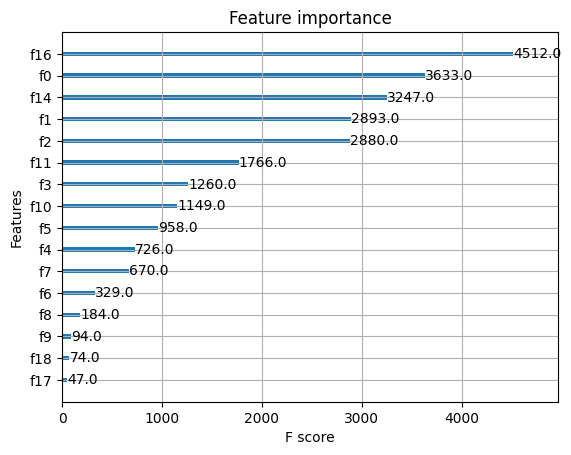

In [93]:
plot_importance(gBm)
plt.show()

In [94]:
scores = cross_val_score(gBm, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.00)


### Incorporate the hyperparameter tuning:

In [95]:
gBm = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,  # Best parameter
    max_depth=7,        # Best parameter
    min_child_weight=1, # Best parameter
    subsample=0.8,      # Best parameter
    colsample_bytree=0.8, # Best parameter
    learning_rate=0.1   # Best parameter
)

# Fit the model with early stopping
gBm.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=10, 
    eval_set=[(X_test, y_test)], 
    verbose=True
)

[0]	validation_0-mlogloss:1.59032
[1]	validation_0-mlogloss:1.43485
[2]	validation_0-mlogloss:1.30443


/Users/seanhalloran/miniconda3/envs/ml-class2/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mlogloss:1.20172
[4]	validation_0-mlogloss:1.10991
[5]	validation_0-mlogloss:1.03526
[6]	validation_0-mlogloss:0.96864
[7]	validation_0-mlogloss:0.91100
[8]	validation_0-mlogloss:0.85617
[9]	validation_0-mlogloss:0.80839
[10]	validation_0-mlogloss:0.76525
[11]	validation_0-mlogloss:0.72705
[12]	validation_0-mlogloss:0.69382
[13]	validation_0-mlogloss:0.66213
[14]	validation_0-mlogloss:0.63507
[15]	validation_0-mlogloss:0.60944
[16]	validation_0-mlogloss:0.58632
[17]	validation_0-mlogloss:0.56532
[18]	validation_0-mlogloss:0.54598
[19]	validation_0-mlogloss:0.52797
[20]	validation_0-mlogloss:0.51265
[21]	validation_0-mlogloss:0.49814
[22]	validation_0-mlogloss:0.48507
[23]	validation_0-mlogloss:0.47284
[24]	validation_0-mlogloss:0.46229
[25]	validation_0-mlogloss:0.45177
[26]	validation_0-mlogloss:0.44211
[27]	validation_0-mlogloss:0.43312
[28]	validation_0-mlogloss:0.42464
[29]	validation_0-mlogloss:0.41704
[30]	validation_0-mlogloss:0.41001
[31]	validation_0-mlogloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

## 6. Evaluate the model and find real feature importances (with names)

In [96]:
scores = cross_val_score(gBm, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.00)


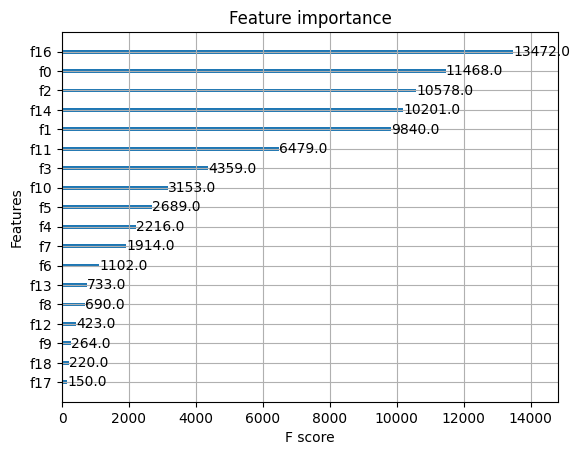

In [97]:
plot_importance(gBm)
plt.show()

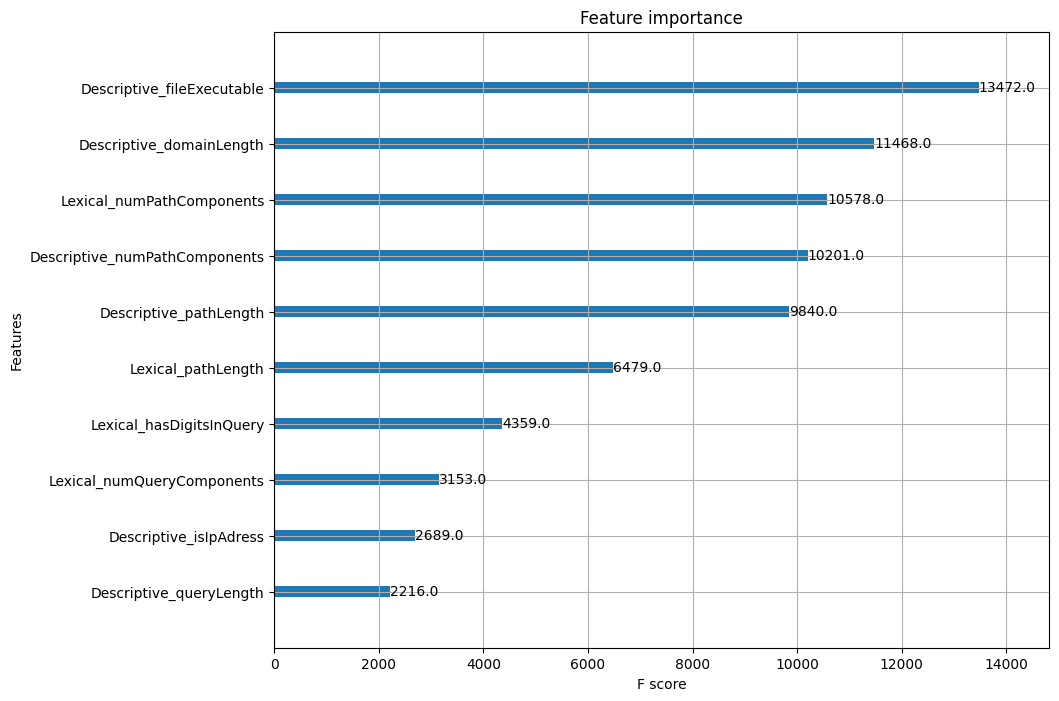

In [98]:
# plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(gBm, ax=ax, importance_type='weight', max_num_features=10, show_values=True)
sorted_idx = np.argsort(gBm.feature_importances_)[-10:] # get it from the model
ax.set_yticklabels(np.array(featureNames)[sorted_idx]) # y tick labels correct this time
plt.show()

In [99]:
print(classification_report(y_test, y_pred_xgb))
y_pred_proba = gBm.predict_proba(X_test) # probs for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print("ROC AUC score:", roc_auc)

              precision    recall  f1-score   support

           0       0.70      0.89      0.78      8492
           1       0.96      0.99      0.98     30792
           2       0.98      1.00      0.99     15291
           3       0.99      0.94      0.96      4485
           4       0.86      0.66      0.75     10863
           5       0.80      0.75      0.77      7797

    accuracy                           0.91     77720
   macro avg       0.88      0.87      0.87     77720
weighted avg       0.91      0.91      0.90     77720

ROC AUC score: 0.9881043303165779


## Further evaluation and interpretation:

### Wow, a ROC AUC of 0.988... is pretty good, the model is performing very well on the test set and likely this would translate to reliable predictions on unseen data. Now we need to test this model with some additional data and try to build a pipeline.

## Of course ROC AUC where AUC means Area Under the Curve is a sum of the performance across all possible classification thresholds (https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). A score of 0.988 as above means the model makes predictions correctly 98.8% of the time. This is a great measurement for our classifier because it measures how well predictions are ranked, rather than absolute values and it mesaures quality of model predictions regardless of the classification threshold (also above for reference).

### Save the model and continue testing and evaluation in `6-pup-model-deployment.ipynb`

In [100]:
# save the model to models-checkpoints folder
joblib.dump(gBm, './models-checkpoints/xgb-model.pkl')

['./models-checkpoints/xgb-model.pkl']